# Supplementary scripts for MintPy derived results

**Author**: Yuan-Kai Liu

**Last updates**: 2020-08-07

#### README:

- The purpose of the scripts in this notebook is to further analyze the results processed from MintPy. User need to first run the related steps in MintPy in order to have the files as inputs in this notebook.

- The documentation and general explanations in this notebook may not be clear enough.

- Make sure you are mot overwriting your original files when you use the notebook (**important !!**).

- Modify the content, paths, input file names, output file names accordingly at your will.

- The seasonal velocity model estimation is not implemented in MintPy yet. User may need to modify their MintPy source code.

# 0-0. Prepare Python Environment

In [1]:
%matplotlib inline

import os
import numpy as np
from copy import copy
import glob
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
from mintpy import view, tsview, plot_network, plot_transection, plot_coherence_matrix
from mintpy.objects import timeseries
from mintpy.utils import readfile
from mintpy.tsview import timeseriesViewer
from datetime import datetime
from mintpy.utils import utils as ut, plot as pp


# Inscrese matplotlib font size when plotting
plt.rcParams.update({'font.size': 16})

# 0-1. Paths

In [2]:
# ----------------------------------------------
# Path settings
# ----------------------------------------------

# where my MintPy dataset stored (my project directory)
proj_dir = os.path.expanduser(os.getcwd())

# where to store generated figures
pic_dir = os.path.expanduser(f'{proj_dir}/pic_supp')

# time-series files to be loaded
ts_file = os.path.expanduser(f'{proj_dir}/timeseries.h5')

# read water mask file
mask_file = os.path.expanduser(f'{proj_dir}/waterMask.h5') 

# go to project directory
os.chdir(proj_dir)

# create pic directory if not exist
if not os.path.exists(pic_dir):
    os.makedirs(pic_dir)
    
# print paths
print(f'MintPy project directory:\t{proj_dir}')
print(f'Pictures will be saved to:\t{proj_dir}')
print(f'Your current directory:\t\t{os.getcwd()}')

MintPy project directory:	/net/kraken/nobak/ykliu/aqaba/aria/a087/ts_ml10_087
Pictures will be saved to:	/net/kraken/nobak/ykliu/aqaba/aria/a087/ts_ml10_087
Your current directory:		/net/kraken/nobak/ykliu/aqaba/aria/a087/ts_ml10_087


# 0-2. Some Self-defined functions:

### not going to use them all

In [3]:
# Read time-series geometry
def read_geo(fname, verbose=False):
    import h5py
    print('reading {}'.format(fname))
    with h5py.File(fname, 'r') as f:
        meta = dict(f.attrs)
        heading   = float(meta['HEADING'])
        incidence = float(meta['incidenceAngle'])
        orbit     = meta['ORBIT_DIRECTION']
        wl        = float(meta['WAVELENGTH']) # meter
        length    = int(meta['LENGTH'])
        width     = int(meta['WIDTH'])
        x_min     = float(meta['X_FIRST'])
        x_step    = float(meta['X_STEP'])
        y_min     = float(meta['Y_FIRST'])
        y_step    = float(meta['Y_STEP'])
        lats      = np.arange(y_min,length*y_step+y_min, y_step)    
        lons      = np.arange(x_min, width*x_step+x_min, x_step)
        ref_lat   = float(meta['REF_LAT'])        
        ref_lon   = float(meta['REF_LON'])
    if verbose is True:
        print(f'\n\tSentinel-1: {orbit}')
        print('\tWavelength = {:.4f} cm'.format(wl*100))
        print('\tHeading = {:.4f} deg\n\tIncidence Angle = {:.4f} deg'.format(heading, incidence))
        print('\tLength = {:}\n\tWidth = {:}'.format(length, width))
        print('\tReference lat \t= {:.4f}\n\tReference lon = {:.4f}'.format(ref_lat, ref_lon))
    return lats, lons, length, width, ref_lat, ref_lon

# --------------------------------------------------------------------------------------------------------
# -------------------------Below are functions not being used, for tsview files I/O ----------------------
# --------------------------------------------------------------------------------------------------------

# Visualization functions
def tsview(fname, yx=None, ptsfile=None):
    """Plot input file using tsview.py"""
    cmd = 'tsview.py {} --ms 4 --ylim -20 20 --multilook-num 10 --save'.format(fname)
    if yx is not None:
        cmd += ' --yx {} {}'.format(yx[0], yx[1])
    if ptsfile is not None:
        cmd += ' --pts-file {} --pts-ms 4'.format(ptsfile)
    #print(cmd)
    obj = timeseriesViewer(cmd)
    obj.configure()
    obj.figsize_img = [5, 4]
    obj.figsize_pts = [5, 2]
    obj.plot()


# Read from tsview profiles output files
def read_tsprofs(profDir):
    files = sorted(glob.glob(f'{profDir}/*.txt'))
    time = []
    disp = []
    py   = []
    px   = []
    lat  = []
    lon  = []
    for i in range(len(files)):
        file = open(files[i],'r')
        lines = file.readlines()
        t = []
        d = []
        for x in lines:
            if x[0] == '#':
                if x[2:5]=='Y/X':
                    tmp = x.split()
                    py.append(tmp[3][:-1])
                    px.append(tmp[4][:-1])
                    lat.append(tmp[7][:-1])
                    lon.append(tmp[8])
                else:
                    continue
            else:
                tmp = x.split()
                t.append(tmp[0])
                d.append(tmp[1])
        if i == 0:
            time = np.array(t)
            disp = np.array(d)
        else:        
            time = np.vstack((np.array(time), np.array(t)))
            disp = np.vstack((np.array(disp), np.array(d)))
    disp = np.array(disp).astype(np.float)
    py = np.array(py).astype(np.float)
    px = np.array(px).astype(np.float)
    lat = np.array(lat).astype(np.float)
    lon = np.array(lon).astype(np.float)
    return time, disp, py, px, lat, lon


# Jointly plot all the time-series 1D profiles
def plot_tsprofs(profDir):
    time, disp, py, px, lat, lon = read_tsprofs(profDir)
    # Make plots
    from matplotlib.dates import (YEARLY, MONTHLY, DateFormatter, rrulewrapper, RRuleLocator)
    import datetime
    plt.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots(nrows=6, ncols=2, figsize=[12,16])
    j=0
    for row in ax:
        for col in row:
            try:
                t = time[j,:]
                y = disp[j,:]
                dates = []
                days = np.zeros(len(t))
                for i in range(len(t)):
                    dates.append(datetime.date(np.int(t[i][:4]), np.int(t[i][4:6]), np.int(t[i][6:8])))
                    days[i] = dates[i].toordinal()               
                import string
                alphabet = string.ascii_uppercase
                pname = list(alphabet)       
                yloc = RRuleLocator(rrulewrapper(YEARLY, byyearday=1))
                mloc = RRuleLocator(rrulewrapper(MONTHLY, bymonthday=1))
                formatter = DateFormatter('%Y')
                col.scatter(days, y, s=10, label=pname[j])
                col.set_ylim(np.mean(y)-25, np.mean(y)+25)
                col.xaxis.set_major_locator(yloc)
                col.xaxis.set_minor_locator(mloc)
                col.xaxis.set_major_formatter(formatter)
                col.legend(loc='upper right')
                col.set_ylabel('Displacement [cm]')
                col.set_title(f'lat={lat[j]}, lon={lon[j]}')
            except:
                col.axis('off')
            j+=1

    plt.tight_layout()
    plt.show()


# Plot one slice of the time-series
def imageSlider(ts_file, dset='timeseries-20150304', mask=None, points=None, return_v=False):
    import matplotlib.gridspec as gridspec
    plt.rcParams.update({'font.size': 16})

    # read ts_file
    ts_obj = timeseries(ts_file)
    ts_obj.open()
    ts_data = readfile.read(ts_file, datasetName=dset)[0].astype("float") * 100. #cm
    numDate = ts_obj.numDate
    dateList = ts_obj.dateList

    # read geometry
    lats, lons, length, width, ref_lat, ref_lon = read_geo(ts_file)

    # read mask
    if mask is not None:
        mask_file = mask
        mask_data = readfile.read(mask_file)[0]
        ts_data[mask_data==0] = np.nan

    # plot
    vmin = -10
    vmax =  10
    cmap=copy(plt.cm.jet)
    cmap.set_bad(color='white')
    fig = plt.figure(figsize=[20, 10])
    ax0 = plt.subplot2grid((2,2), (0,0), colspan=1, rowspan=2)
    im = ax0.imshow(ts_data[:, :], extent=[lons[0],lons[-1],lats[-1],lats[0]], vmin=vmin, vmax=vmax, cmap=cmap)
    ax0.set_title('{} residual'.format(dset))
    plt.colorbar(im, ax=ax0, cmap=cmap, extend='both', aspect=50, shrink=0.8, pad=0.01, label='Displacement [cm]')
    if points is not None: # read tsview output files for lon lat of custom pixels
        _, _, _, _, plat, plon = read_tsprofs(points)            
        import string
        alphabet = string.ascii_uppercase
        pname = list(alphabet)
        for i in range(len(plat)):
            ax0.scatter(plon[i], plat[i], s=40, marker='^', c='red', edgecolor='k')
            ax0.text(plon[i], plat[i], pname[i], fontsize=16)
    ax0.scatter(ref_lon, ref_lat, marker='s', s=50, c='k')
    # plot scale bar
    sblon = 34 # deg, lon location
    sblat = 27 # deg, lat location
    sbr   = 99 # km, distance for 1 longitude deg at sblat
    sblen = 80 # km, total length
    ax0.plot(np.array([sblon, sblon+sblen/sbr]), np.array([sblat, sblat]), linewidth=4, c='k')
    ax0.text(0.5*(sblon+sblon+sblen/sbr), sblat-0.3, f'{sblen} km', ha='center')        
    
    data = ts_data[:, :]
    data = data[~np.isnan(data)]
    data_rms = np.sqrt(np.sum(data**2)/len(data))
    ax1 = plt.subplot2grid((2,2), (0,1))
    bins = np.linspace(np.min(data), np.max(data), 500)
    ax1.hist(data, bins, density=True)
    ax1.set_xlim([-10,10])
    ax1.set_ylim([0,0.6])
    ax1.set_xlabel('Residual [cm]')
    ax1.set_ylabel('Density')
    ax1.set_title('Residual distribution, RMS={:.2f}'.format(data_rms))
    plt.show()
    

    if return_v is True:
        return ts_data

# 0-3. Write a code for Velocity estimation

### Define: 

- Polynomial models (can be linear model if the polynomial degree = 1)

- Sine and Cosine models (seasonal models)

- Step funtions (coseismic models)

In [4]:
# FILL IN (only inside the functions)

# columns of the G matrix for a polynomial model
def get_polynomial(dt, degree=1):
    # input:
    #  - dt of shape (nt, ) in years since refDate
    # output:
    #  - Gcols of shape (nt, degree + 1) of the linear coefficients
    Gcols = np.empty((dt.size, degree + 1))
    for i in range(degree+1):
        Gcols[:,i] = dt**i
    return Gcols

# columns of the G matrix for a sinusoid model
def get_sinusoidal(dt, period=1):
    # input:
    #  - dt of shape (nt, ) in years since refDate
    #  - period in years
    # output:
    #  - Gcols of shape (nt, 2) of the sin and cos coefficients
    Gcols = np.empty((dt.size, 2))
    Gcols[:,0] = np.cos(dt*2*np.pi/period)
    Gcols[:,1] = np.sin(dt*2*np.pi/period)
    return Gcols

# columns of the G matrix for a step function
def get_step(dt, tstep):
    # input:
    #  - dt of shape (nt, ) in years since refDate
    #  - step time tstep in years since refDate
    # output:
    #  - Gcols of shape (nt, 1) of the step coefficients (zeros and ones)
    Gcols = np.zeros(dt.size)
    idx = (np.abs(dt-tstep)).argmin()
    Gcols[idx:] = 1
    return Gcols

# here, we combine all the individual models
def get_G(timevector, poly_degree, sin_periods=[], steps=[], refDate=None):
    # input:
    #  - timevector of shape (nt, ) in years
    #  - integer polynomial degree (0 for a constant, 1 for linear, 2 for quadratic, etc.)
    #  - a list of sinusoidal periods (for example [1, 0.5] for annual and semiannual)
    #  - a list of step times (for example [2006.0, 2007.0] for the 2006 and 2007 New Year's) in decimal years
    # output:
    #  - G matrix of shape (nt, polynomial degree+1 + 2*number of seasonals + number of logarithms + number of steps)
    
    if refDate is None:
        refDate = timevector[0]
    dt = timevector - refDate
    
    num_params = (poly_degree + 1) + 2*len(sin_periods) + len(steps)
    G = np.empty((dt.size, num_params))
    # insert linear part
    G[:, 0:poly_degree+1] = get_polynomial(dt, degree=poly_degree)
    # insert all seasonal parts
    icol = poly_degree + 1
    for per in sin_periods:
        G[:, icol:icol+2] = get_sinusoidal(dt, period=per)
        icol += 2
    # insert all steps
    for tstep in steps:
        G[:, icol] = get_step(dt, tstep=tstep-refDate)
        icol += 1
    # return
    return G

def inv_param(t, dis, poly_degree=1, sin_periods=[], steps=[]):
    # set G matrix, linear (degree=1)
    G = get_G(t, poly_degree, sin_periods, steps)
    
    # solve for model parameters (intercetps and slopes in this case)
    m = np.linalg.lstsq(G, dis, rcond=None)[0]

    # get estimated linear velocity 
    vel_est = m[1]
    
    # get the estimated displacement
    dis_est = G @ m

    # calculate the displacement residual and velocity STD
    dis_resid = dis - dis_est
    vel_std = np.sqrt(np.sum(np.square(dis - dis_est)) / (np.sum(np.square(t - np.mean(t)))) / (len(t) - 2))
    
    # calculate the root-mean-square-error (RMSE)
    rmse = np.sqrt(np.sum(dis_resid**2)/len(t))
    
    # print dimension
    dim_print = 0
    if dim_print == 1:
        print('Design matrix, A:', G.shape)
        print('Data, ts_obs:', dis.shape)
        print('Date, date_list:', t.shape)
        print('Parameters, X:', m.shape)
    
    return [m, vel_est, vel_std, dis_est, dis_resid, rmse]

# 1. Initialization

In [5]:
# ----------------------------------------------
# Initialization:
# ----------------------------------------------

# Points of interest ( pixel coordinates: [along-track, range] )
coast_pix = np.array( [[505,169], [554,157], [600,153], [640,139], [648,201], [687,228], [740,266], [801,305]])
inland_pix = np.array([[339,267], [388,274], [451,290], [512,306], [559,328], [620,345], [668,360], [739,337]])

ordered = 0  # 0 for y-coordinate; 1 for x corrdinate
reverse = 0  # 0 for non-reversed; 1 for reversed order
if reverse == 0:
    coast_pix = coast_pix[np.argsort(coast_pix[:,ordered]),:]
    inland_pix = inland_pix[np.argsort(inland_pix[:,ordered]),:]
elif reverse == 1:
    coast_pix = coast_pix[np.argsort(coast_pix[:,ordered]),:][::-1]
    inland_pix = inland_pix[np.argsort(inland_pix[:,ordered]),:][::-1]

# get geometry info
lats, lons, length, width, ref_lat, ref_lon = read_geo(ts_file, verbose=True)

# Save user selected pixels to txt files
for i in range(2):
    if i == 0:
        plats = lats[coast_pix[:,0]]
        plons = lons[coast_pix[:,1]]
        txtfile = 'pixels_coast.txt'        
    elif i == 1:
        plats = lats[inland_pix[:,0]]
        plons = lons[inland_pix[:,1]]
        txtfile = 'pixels_inland.txt'

    tmp=[]
    with open(txtfile, 'w+') as file:
        for i in range(len(plats)):
            tmp = [plats[i], plons[i]]
            file.write('%s  '*2%(tmp[0],tmp[1])+'\n')
        print(f'Complete writing to file: {txtfile}') 

reading /net/kraken/nobak/ykliu/aqaba/aria/a087/ts_ml10_087/timeseries.h5

	Sentinel-1: ASCENDING
	Wavelength = 5.5466 cm
	Heading = -12.0000 deg
	Incidence Angle = 38.3970 deg
	Length = 883
	Width = 485
	Reference lat 	= 29.9983
	Reference lon = 36.0033
Complete writing to file: pixels_coast.txt
Complete writing to file: pixels_inland.txt


run view.py in MintPy release version v1.2beta-237, release date 2020-08-08
input file is velocity file: /net/kraken/nobak/ykliu/aqaba/aria/a087/ts_ml10_087/velocity_linear_2/velocity.h5 in float32 format
file size in y/x: (883, 485)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 2
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 485, 883)
subset coverage in y/x: (0, 0, 485, 883)
data   coverage in lat/lon: (33.5575, 33.494166667, 37.599166505, 26.135833628000004)
subset coverage in lat/lon: (33.5575, 33.494166667, 37.599166505, 26.135833628000004)
------------------------------------------------------------------------
colormap: jet
read points lat/lon from text file: /net/kraken/nobak/ykliu/aqaba/aria/a087/ts_ml10_087/pixels_coast.txt
figure title: velocity
figure size : [5.49, 8.00]
read mask from file: waterMask.h5
reading data ...
masking data
data    range: [-4.2062716, 1

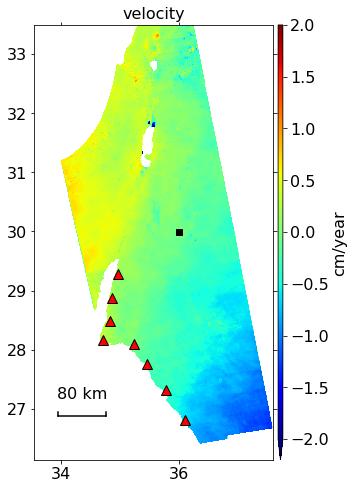

In [11]:
file = [f'{proj_dir}/velocity_linear_2/velocity.h5', 'velocity']
opt  = ['--pts-marker', 'r^', '--pts-ms', '10', '--vlim', '-2', '2', '--mask', 'waterMask.h5']
pts  = ['--pts-file', f'{proj_dir}/pixels_coast.txt']

view.main(file+opt+pts)

# 2. Look at my time-series displacement

### Try to demonstrate the steps of how I clean-up the time series (just show the time series from one pixel)

The raw time series generated by MintPy using `network_inversion` are phases contributed by the following stuff:

- **deformation** (usually very tiny for interseismic deformation field)

- **troposphere delay** (big effects! Usually can be accounted using weather model like ERA5 model)

- **geometrical error** (small effects; e.g., DEM. Can be accounted in MintPy)

- **residual** (e.g., ionosphere delay, turbulence troposhpere, ocean tidal laod, solid earth tides, phase unwrapping error, decorrelation, ... all sorts of other unwanted physical or processing effects) This we need to evaluate, model, correct, remove them ourselves!!

See **Supp 1.** for simple expression using equations.

#### Files generated by MintPy:

- Raw time-series displacements: `timeseries.h5`

- Raw time-series displacements $+$ troposphere correction: `timeseries_ERA5.h5`

- Raw time-series displacements $+$ troposphere correction $+$ DEM correction: `timeseries_ERA5_demErr.h5`


#### Need to calculate here:

- Troposphere correction: `timeseries.h5` $-$ `timeseries_ERA5.h5`

- DEM error: `timeseries_ERA5.h5` $-$ `timeseries_ERA5_demErr.h5`

In [14]:
from datetime import datetime
import time

def date2decimalyear(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch
    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)
    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration
    return date.year + fraction

def plot_ts_step(ts_file, ts_file_tro, ts_file_dem, pts_file, pts, fig_dpi=300):
    ts_file = os.path.expanduser(f'{proj_dir}/{ts_file}')
    ts_file_tro = os.path.expanduser(f'{proj_dir}/{ts_file_tro}')
    ts_file_dem = os.path.expanduser(f'{proj_dir}/{ts_file_dem}')
    
    # give a point to plot
    import string
    pix_name = list(string.ascii_uppercase)
    idx = pix_name.index(pts)
    
    # read points file
    file = open(f'{pts_file}','r')
    lines = file.readlines()
    i=0
    for x in lines:
        if i==idx:
            tmp = x.split()
            plat, plon = float(tmp[0]), float(tmp[1])
        i+=1
    print(plat, plon)
    
    
    # read data
    dates, dis_raw = ut.read_timeseries_lalo(lat=plat, lon=plon, ts_file=ts_file, win_size=1, unit='cm', print_msg=False)
    dates, dis_raw_tro = ut.read_timeseries_lalo(lat=plat, lon=plon, ts_file=ts_file_tro, win_size=1, unit='cm', print_msg=False)
    dates, dis_raw_tro_dem = ut.read_timeseries_lalo(lat=plat, lon=plon, ts_file=ts_file_dem, win_size=1, unit='cm', print_msg=False)

    dis_final = dis_raw_tro_dem
    dis_dem = dis_raw_tro - dis_raw_tro_dem
    dis_tro = dis_raw - dis_raw_tro

    
    # Convert decimal years
    yr_list = [i.year + (i.timetuple().tm_yday - 1) / 365.25 for i in dates]
    yr_diff = np.array(yr_list)
    
    
    # Get line fits for raw timeseries and tropo-corrected timeseries
    poly_degree=1
    sin_periods=[]
    steps=[]
    ## raw timeseries
    X = inv_param(yr_diff, dis_raw, poly_degree, sin_periods, steps)
    v0, dis_est0, rms0 = X[1], X[3], X[5]
    ## tropo-corrected, dem corrected timeseries
    X = inv_param(yr_diff, dis_final, poly_degree, sin_periods, steps)
    v1, dis_est1, rms1 = X[1], X[3], X[5]


    # plot
    font_size=16
    plt.rcParams.update({'font.size': font_size})    
    fig, ax = plt.subplots(figsize=[12,10])        
    ax.scatter(dates, dis_raw  +20*3  , marker='^', s=6**2, linewidth=1., label='Raw time series')
    ax.scatter(dates, dis_tro  +20*2  , marker='^', s=6**2, linewidth=1., label='delay from troposphere')
    ax.scatter(dates, dis_dem  +20*1  , marker='^', s=6**2, linewidth=1., label='delay from DEM error')
    ax.scatter(dates, dis_final+20*0  , marker='^', s=6**2, linewidth=1., label='Time series after corrections')
    ax.plot(   dates, dis_est0 +20*3, '-', lw=2, c='k')
    ax.plot(   dates, dis_est1 +20*0, '-', lw=2, c='k')
    txtloc = 10
    ax.text(dates[txtloc], dis_est0[txtloc]+20*3+3, 'V={:.2f}, RMSE={:.2f}'.format(v0, rms0))
    ax.text(dates[txtloc], dis_est1[txtloc]+20*0+3, 'V={:.2f}, RMSE={:.2f}'.format(v1, rms1))
    

    # axis format
    pp.auto_adjust_xaxis_date(ax, dates, fontsize=font_size)
    ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True)
    ax.set_ylim(np.min(dis_final)-5, np.max(dis_raw)+20*4)
    ax.legend(loc='upper right')                    
    ax.set_xlabel('Time [year]', fontsize=20)
    ax.set_ylabel('Range change history [cm], (relative)', fontsize=20)
    ax.set_title(f'Time-series displacement at pixel: {pts}')
    
    # output
    out_file = f'{pic_dir}/pixel{pts}_ts_processing.png'
    plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
    print('save to file: '+out_file)
    plt.show()

27.769166895997905 35.45749992400069
save to file: /net/kraken/nobak/ykliu/aqaba/aria/a087/ts_ml10_087/pic_supp/pixelF_ts_processing.png


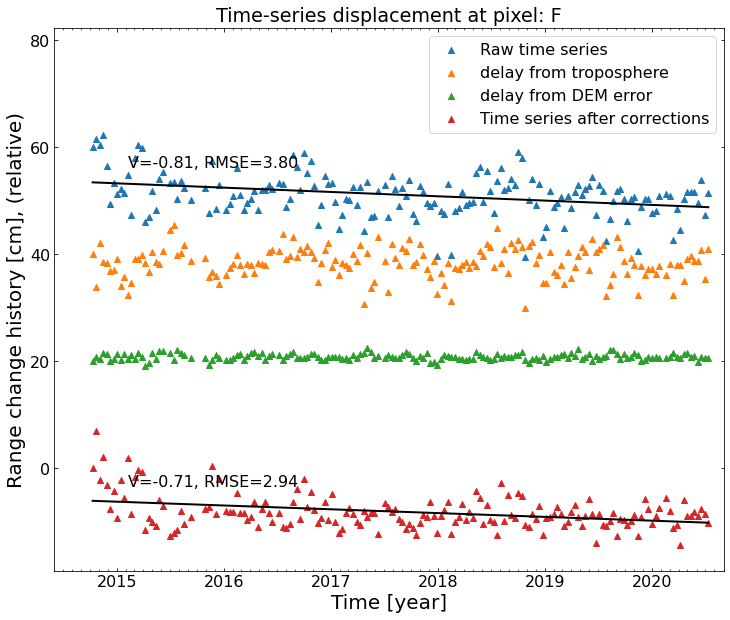

In [15]:
ts_file     = 'timeseries.h5'
ts_file_tro = 'timeseries_ERA5.h5'
ts_file_dem = 'timeseries_ERA5_demErr.h5'
pts_file    = 'pixels_coast.txt'

plot_ts_step(ts_file, ts_file_tro, ts_file_dem, pts_file, pts='F', fig_dpi=300)

# 3. Estimate the time series at all my self-defined pixels

## use different models:

- Linear secular velocity model

- Include periodic seasonal models as well

In [16]:
from datetime import datetime
import time
import sys

def dtstr(datestr):
    if isinstance(datestr, list) == False:
        if len(datestr) != 8:
            print('Date input error: enter YYYYMMDD string format')
            sys.exit()
        y = int(datestr[:4])
        m = int(datestr[4:6])
        d = int(datestr[6:8])
        dt = datetime(y,m,d)
    elif isinstance(datestr, list) == True:
        dt = []
        for i in range(len(datestr)):
            if len(datestr[i]) != 8:
                print('Date input error: enter YYYYMMDD string format')
                sys.exit()
            y = int(datestr[i][:4])
            m = int(datestr[i][4:6])
            d = int(datestr[i][6:8])
            dt.append(datetime(y,m,d))
    return dt


def checkdt(dates, dis, startdt=None, enddt=None, excdt=[]):
    yr_list = []
    new_dis = []
    new_dates = []
    for i in range(len(dates)):
        dd = dates[i]
        if startdt is not None:
            if dd<startdt:
                #print('exclude date {:04d}{:02d}{:02d}'.format(dd.year,dd.month,dd.day))
                continue
        if enddt is not None:
            if dd>enddt:
                #print('exclude date {:04d}{:02d}{:02d}'.format(dd.year,dd.month,dd.day))
                continue
        if len(excdt) != 0:
            if dd in excdt:
                #print('exclude date {:04d}{:02d}{:02d}'.format(dd.year,dd.month,dd.day))
                continue                
        yr_list.append(dd.year + (dd.timetuple().tm_yday - 1) / 365.25)
        new_dis.append(dis[i])
        new_dates.append(dates[i])
    yr_diff = np.array(yr_list)
    new_dis = np.array(new_dis)
    return yr_diff, new_dis, new_dates


def plot_timeseries(ts_file, pts, model='linear', startDate=None, endDate=None, excDate=[], fig_dpi=300):
    ts_file = os.path.expanduser(f'{proj_dir}/{ts_file}')
    pts_file = f'pixels_{pts}.txt'
    
    # read points file
    file = open(f'{pts_file}','r')
    lines = file.readlines()
    plats = []
    plons = []
    for x in lines:
        tmp = x.split()
        plats.append(float(tmp[0]))
        plons.append(float(tmp[1]))    

    # points name
    import string
    alphabet = string.ascii_uppercase
    pix_name = list(alphabet)
    
    # plotting setup
    plot_fitting = 1
    plot_residual = 1
    font_size=16
    plt.rcParams.update({'font.size': font_size})
    nrows, ncols = int(np.round(len(plats)/2)), 2
    
    # save values for the residual plot
    dis_resids=[]
    rmses=[]
    
    # models (default: linear fitting)
    poly_degree=1
    sin_periods=[]
    steps=[]
    if model == 'linear':
        print('Linear fitting')
    elif model == 'periodic':
        print('Linear + periodic fitting')
        sin_periods=[1.0, 0.5]
    else:
        print('Erorr: wrong model input')
    
    # Dates modification
    if startDate is not None:
        print(f'Start date: {startDate}')
        startdt = dtstr(startDate)
    else:
        startdt = None
    if endDate is not None:
        print(f'End date: {endDate}')        
        enddt = dtstr(endDate)
    else:
        enddt = None
    if excDate != []:
        print(f'Exclude date(s): {excDate}')                
        excdt = dtstr(excDate)
    else:
        excdt = []
    

    # plots
    vmin = -12
    vmax =  12
    if plot_fitting == 1:
        title = f'Mean removed time series, {model} fit ({pts} pixels)'
        fname = f'ts_{pts}_{model}'
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, gridspec_kw={'hspace':0.1, 'wspace':0.02}, figsize=[ncols*8,nrows*2])
        i=0
        for row in ax:
            for col in row:
                lat = plats[i]
                lon = plons[i]
                Dates, Dis = ut.read_timeseries_lalo(lat=lat, lon=lon, ts_file=ts_file, win_size=1, unit='cm', print_msg=False)

                yr_diff, dis, dates = checkdt(Dates, Dis)                
                yr_diff_up, dis_up, dates_up = checkdt(Dates, Dis, startdt, enddt, excdt)                
                
                # Convert decimal years
                #yr_list = [dd.year + (dd.timetuple().tm_yday - 1) / 365.25 for dd in dates]
                #yr_diff = np.array(yr_list)
                
                # Inversion for velocity
                ## option 1 - my customized method 
                X = inv_param(yr_diff, dis, poly_degree, sin_periods, steps)
                m, vel_est, vel_std, dis_est, dis_resid, rmse = X[0], X[1], X[2], X[3], X[4], X[5]
                dis_resids.append(dis_resid)
                rmses.append(rmse)
                
                plotUpdate = 0
                if dates_up != dates:
                    plotUpdate = 1
                    X = inv_param(yr_diff_up, dis_up, poly_degree, sin_periods, steps)
                    m_up, vel_est_up, vel_std_up, dis_est_up, dis_resid_up, rmse_up = X[0], X[1], X[2], X[3], X[4], X[5]
                    #dis_resids.append(dis_resid)
                    #rmses.append(rmse)                    
                    

                # plot
                col.scatter(dates, dis-np.mean(dis), marker='^', s=6**2, facecolors='none', edgecolors='k', linewidth=1.)
                col.plot(dates, dis_est-np.mean(dis_est), '-', lw=2, c='crimson', label='{} ({:.2f} cm/y, RMSE={:.2f} cm)'.format(pix_name[i],vel_est,rmse))
                if plotUpdate == 1:
                    col.plot(dates_up, dis_est_up-np.mean(dis_est_up), '-', lw=2, c='slateblue', label='{} ({:.2f} cm/y, RMSE={:.2f} cm)'.format(pix_name[i],vel_est_up,rmse_up))

                # axis format
                pp.auto_adjust_xaxis_date(col, dates, fontsize=font_size)
                col.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True)
                col.set_ylim(vmin, vmax)
                #col.text(dates[0], 8, 'RMSE={:.2f} cm'.format(rmse))
                #col.text(dates[0],-8, 'VelStd={:.2f} cm/yr'.format(vel_std))
                col.legend(loc='upper right', fontsize=10, frameon=False)                    
                i+=1
        fig.text(0.50, 0.06, 'Time [year]', ha='center', va='center', fontsize=20)
        fig.text(0.06, 0.50, 'LOS displacement [cm]', ha='center', va='center', rotation='vertical', fontsize=20)
        fig.text(0.50, 0.90, title, ha='center', va='center', fontsize=20)

        # output
        out_file = f'{pic_dir}/{fname}.png'
        plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
        print('save to file: '+out_file)
        plt.show()
        
    if plot_residual == 1:
        title = f'Time-series residual, {model} fit ({pts} pixels)'
        fname = f'tsResid_{pts}_{model}'        
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, gridspec_kw={'hspace':0.1, 'wspace':0.02}, figsize=[ncols*8,nrows*2])
        i=0
        for row in ax:
            for col in row:
                try:
                    # plot
                    col.scatter(dates, dis_resids[i], marker='.', label='{} (RMSE={:.2f})'.format(pix_name[i], rmses[i]))

                    # axis format
                    pp.auto_adjust_xaxis_date(col, dates, fontsize=font_size)
                    col.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True)
                    col.set_ylim(vmin, vmax)
                    col.legend(loc='upper right', frameon=False)                    
                except:
                    col.axis('off')
                i+=1
        fig.text(0.50, 0.06, 'Time [year]', ha='center', va='center', fontsize=20)
        fig.text(0.06, 0.50, 'LOS Residual [cm]', ha='center', va='center', rotation='vertical', fontsize=20)
        fig.text(0.50, 0.90, title, ha='center', va='center', fontsize=20)

        # output
        out_file = f'{pic_dir}/{fname}.png'
        plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
        print('save to file: '+out_file)
        plt.show()

Linear fitting
Start date: 20160101
save to file: /net/kraken/nobak/ykliu/aqaba/aria/a087/ts_ml10_087/pic_supp/ts_coast_linear.png


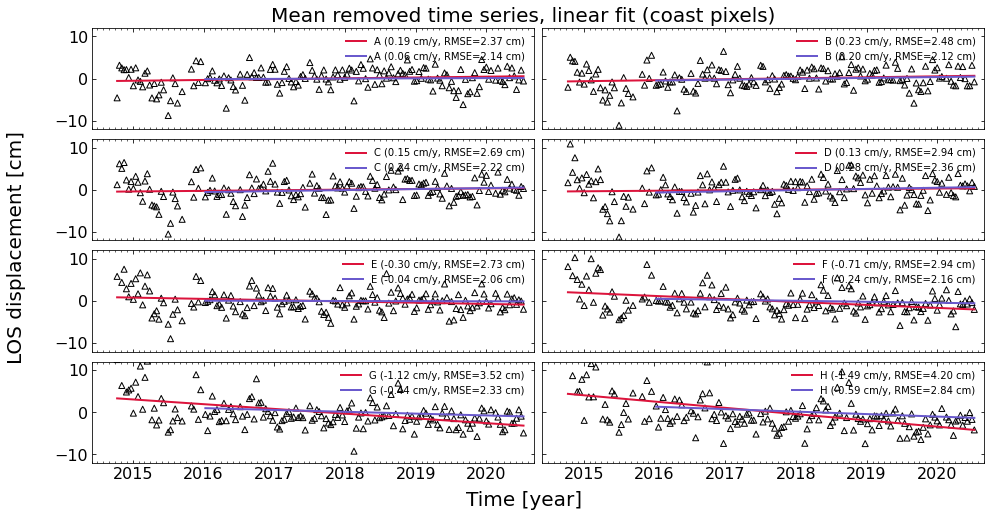

save to file: /net/kraken/nobak/ykliu/aqaba/aria/a087/ts_ml10_087/pic_supp/tsResid_coast_linear.png


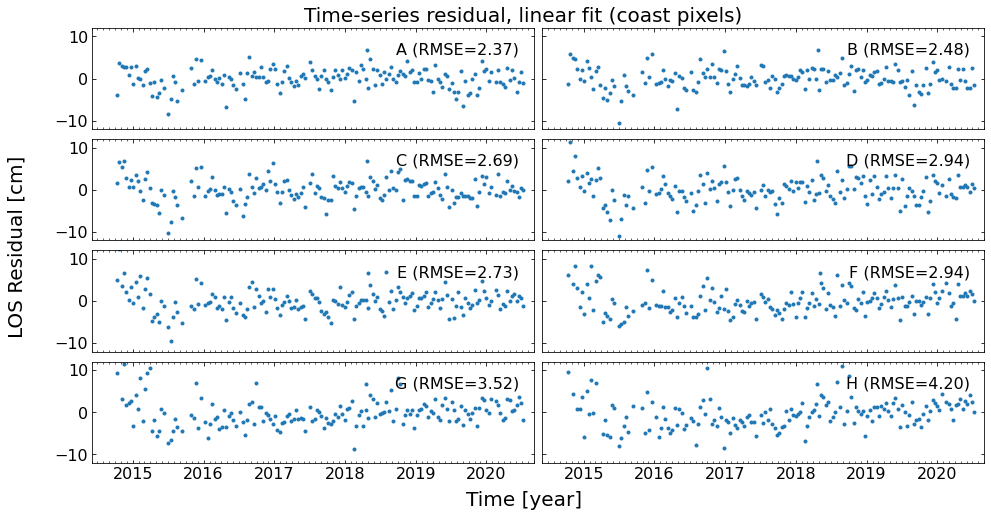

Linear + periodic fitting
Start date: 20160101
save to file: /net/kraken/nobak/ykliu/aqaba/aria/a087/ts_ml10_087/pic_supp/ts_coast_periodic.png


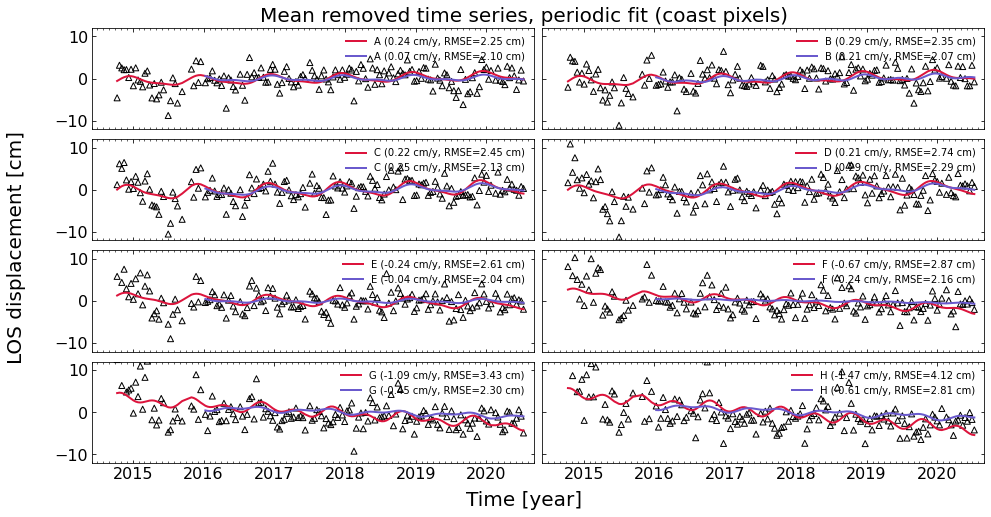

save to file: /net/kraken/nobak/ykliu/aqaba/aria/a087/ts_ml10_087/pic_supp/tsResid_coast_periodic.png


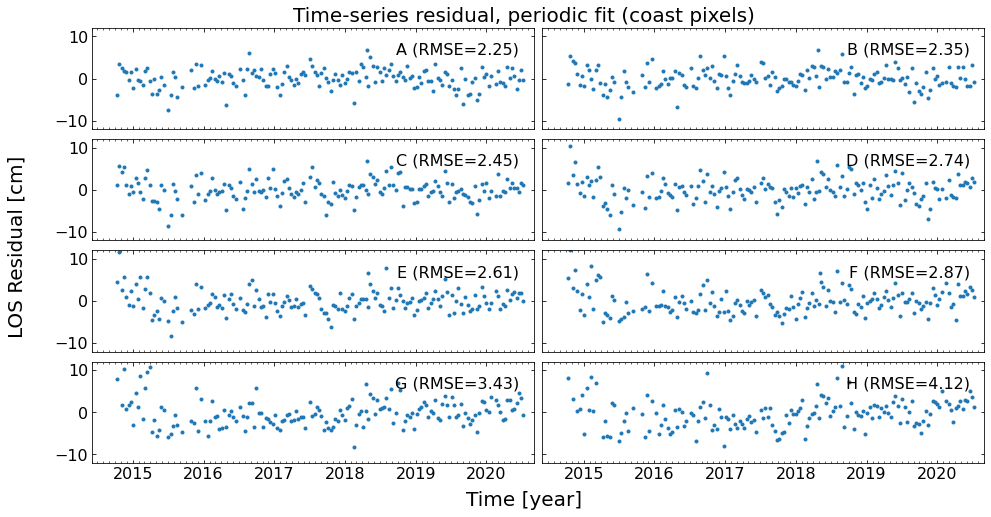

Linear fitting
Start date: 20160101
save to file: /net/kraken/nobak/ykliu/aqaba/aria/a087/ts_ml10_087/pic_supp/ts_inland_linear.png


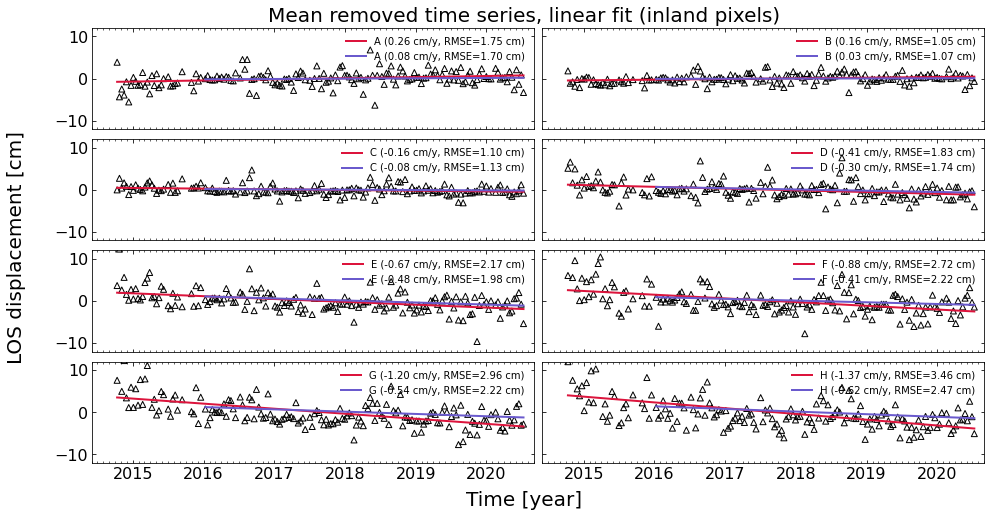

save to file: /net/kraken/nobak/ykliu/aqaba/aria/a087/ts_ml10_087/pic_supp/tsResid_inland_linear.png


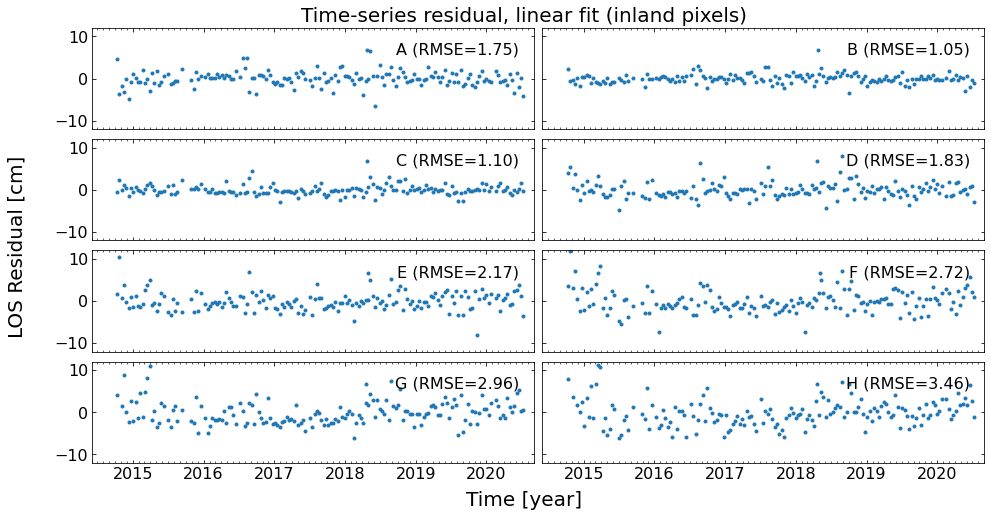

Linear + periodic fitting
Start date: 20160101
save to file: /net/kraken/nobak/ykliu/aqaba/aria/a087/ts_ml10_087/pic_supp/ts_inland_periodic.png


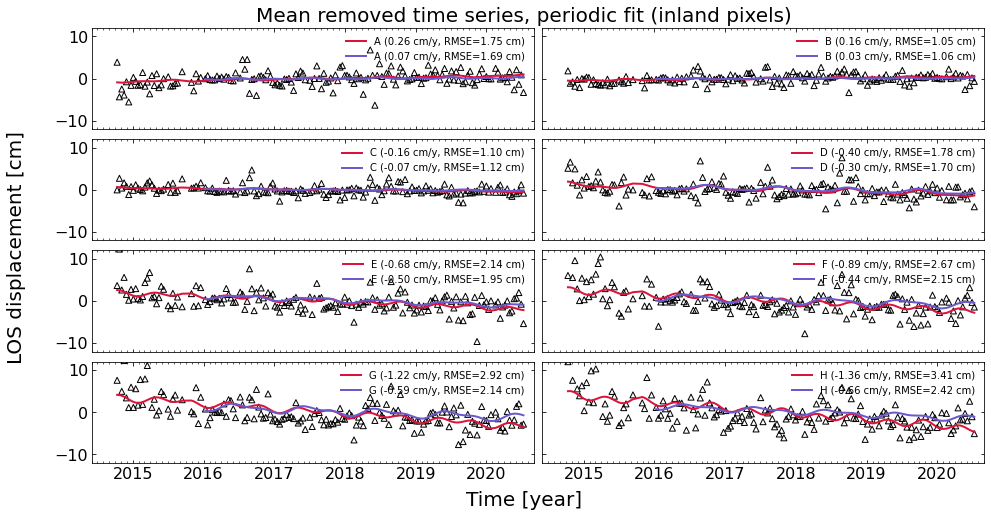

save to file: /net/kraken/nobak/ykliu/aqaba/aria/a087/ts_ml10_087/pic_supp/tsResid_inland_periodic.png


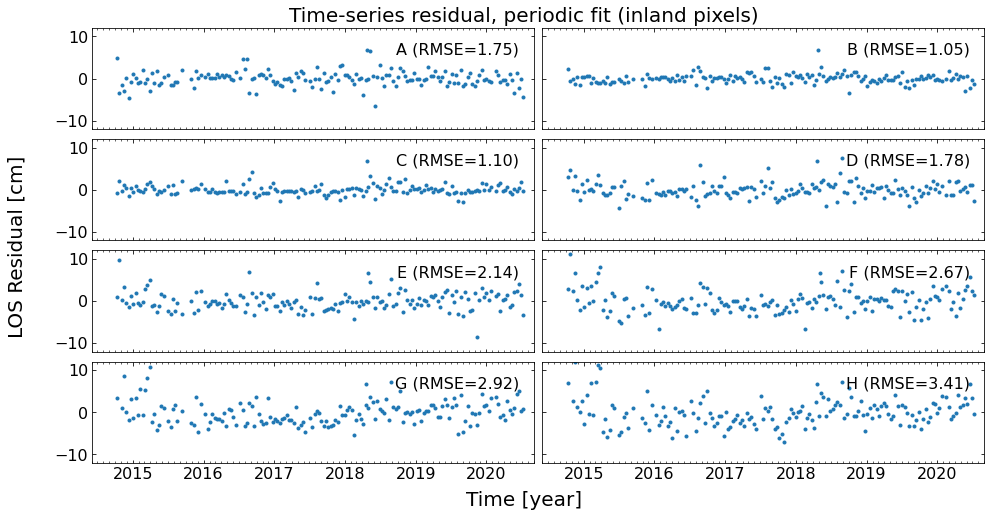

In [17]:
plot_timeseries(ts_file='timeseries_ERA5_demErr.h5', pts='coast' , model='linear'  , startDate='20160101')
plot_timeseries(ts_file='timeseries_ERA5_demErr.h5', pts='coast' , model='periodic', startDate='20160101')
plot_timeseries(ts_file='timeseries_ERA5_demErr.h5', pts='inland', model='linear'  , startDate='20160101')
plot_timeseries(ts_file='timeseries_ERA5_demErr.h5', pts='inland', model='periodic', startDate='20160101')

# 4. Plot Velocity Maps (different models)

#### The script down here will try to read velocity.h5 file based on seasonal models. If you don't have them you will end up having errors.

#### The MintPy source code should be modified in order to run `velocity` step in mintpy with seasonal models. Currently, MintPy only has linear model. To use seasonal model, we need to implement it ourselves in the source code. I have made some implementations there and tested it, it proves to be working. But I haven't made a pull request of my own branch (contribute/submit my codes) on GitHub to be reviewed and approved. 


In [22]:
def plot_velocitymap(data, pts, model='linear', fig_dpi=300, vmin=-2, vmax=2, stdmax=0.4, ampmax=2.4, plot_seasonalAmp=False, gv=False):
    velo_file = f'velocity_{model}_2/{data}.h5'
    fname = f'{data}_{pts}_{model}_2'
    
    # model (default: plot the linear model results)
    if model=='linear':
        print('Linear fitting')
    elif model=='periodic':
        print('Linear + periodic fitting')
    else:
        print('Erorr: wrong model input')        
    
    v     = readfile.read(velo_file, datasetName='velocity')[0]*100
    meta  = readfile.read(velo_file, datasetName='velocity')[1]
    v_std = readfile.read(velo_file, datasetName='velocityStd')[0]*100
    if plot_seasonalAmp == True:
        try:
            s_amp = readfile.read(velo_file, datasetName='seasonalAmp')[0]*100
        except:
            print('Error: no seasonal amplitude data found!!')

    # read lat/lon info
    try:
        length    = int(meta['LENGTH'])
        width     = int(meta['WIDTH'])
        x_min     = float(meta['X_FIRST'])
        x_step    = float(meta['X_STEP'])
        y_min     = float(meta['Y_FIRST'])
        y_step    = float(meta['Y_STEP'])
        lats      = np.arange(y_min,length*y_step+y_min, y_step)    
        lons      = np.arange(x_min, width*x_step+x_min, x_step)
        ref_lat   = float(meta['REF_LAT'])
        ref_lon   = float(meta['REF_LON'])
    except:
        pass
    
    # read mask and mask the dataset
    mask_file = 'maskTempCoh.h5'   # 'waterMask.h5' or 'maskTempCoh.h5'
    mask_data = readfile.read(mask_file)[0]
    v[mask_data==0] = np.nan
    v_std[mask_data==0] = np.nan
    if plot_seasonalAmp == True:
        s_amp[mask_data==0] = np.nan

    # read points file
    pts_file = f'pixels_{pts}.txt'
    file = open(f'{pts_file}','r')
    lines = file.readlines()
    plats = []
    plons = []
    for x in lines:
        tmp = x.split()
        plats.append(float(tmp[0]))
        plons.append(float(tmp[1]))

    # points name
    import string
    alphabet = string.ascii_uppercase
    pix_name = list(alphabet)    
    
    # plot
    font_size=16
    plt.rcParams.update({'font.size': font_size})    
    cmap='jet'
    nrows, ncols = 1, 2
    if plot_seasonalAmp == True:
        ncols = 3
        
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[ncols*8,12])
    im0 = ax[0].imshow(v, extent=[lons[0],lons[-1],lats[-1],lats[0]],vmin=vmin, vmax=vmax, cmap=cmap)
    im1 = ax[1].imshow(v_std, extent=[lons[0],lons[-1],lats[-1],lats[0]],vmin=0, vmax=stdmax, cmap=cmap)
    if plot_seasonalAmp == True:
        im2 = ax[2].imshow(s_amp, extent=[lons[0],lons[-1],lats[-1],lats[0]],vmin=0, vmax=ampmax, cmap=cmap)
    
    # axis format
    ax[0].set_title(f'{data}, {model} fit')
    ax[1].set_title(f'Std of {data}, {model} fit')
    fig.colorbar(im0, ax=ax[0], cmap=cmap, extend='both', aspect=50, shrink=0.8, pad=0.01, label='cm/year')    
    fig.colorbar(im1, ax=ax[1], cmap=cmap, extend='both', aspect=50, shrink=0.8, pad=0.01, label='cm/year')
    if plot_seasonalAmp == True:
        ax[2].set_title(f'Seasonal amp. of {data}')
        fig.colorbar(im2, ax=ax[2], cmap=cmap, extend='both', aspect=50, shrink=0.8, pad=0.01, label='cm') 

    # set scale bar
    sblon = 34 # deg, lon location
    sblat = 27 # deg, lat location
    sbr   = 99 # km, distance for 1 longitude deg at sblat
    sblen = 80 # km, total length    
    
    # plot other info
    for j in range(ncols):
        for i in range(len(plats)):
            ax[j].scatter(plons[i], plats[i], s=40, marker='^', c='red', edgecolor='k')
            ax[j].text(plons[i], plats[i], pix_name[i], fontsize=16)
        try:
            ax[j].scatter(ref_lon, ref_lat, marker='s', s=50, c='k')
        except:
            pass
        ax[j].plot(np.array([sblon, sblon+sblen/sbr]), np.array([sblat, sblat]), linewidth=4, c='k')
        ax[j].text(0.5*(sblon+sblon+sblen/sbr), sblat-0.3, f'{sblen} km', ha='center')          
        ax[j].set_xlabel('Longitude')
        ax[j].set_ylabel('Latitude')
    
    # output
    out_file = f'{pic_dir}/{fname}.png'
    plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
    print('save to file: '+out_file)
    plt.show()
    
    if gv is True:
        return v, v_std, meta

Linear fitting
save to file: /net/kraken/nobak/ykliu/aqaba/aria/a087/ts_ml10_087/pic_supp/velocity_coast_linear_2.png


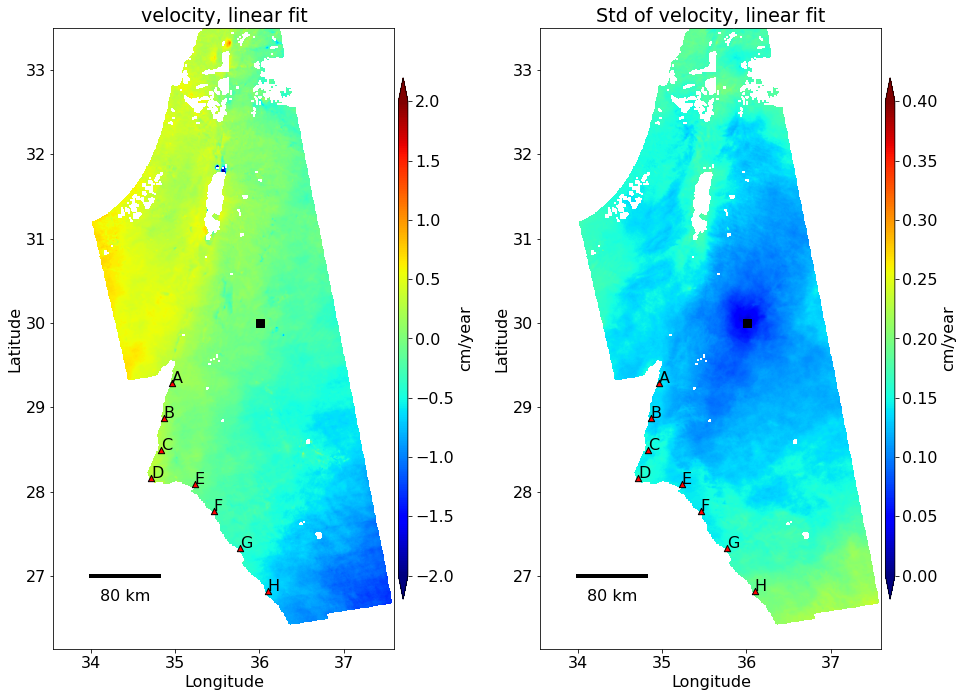

Linear fitting
save to file: /net/kraken/nobak/ykliu/aqaba/aria/a087/ts_ml10_087/pic_supp/velocityERA5_coast_linear_2.png


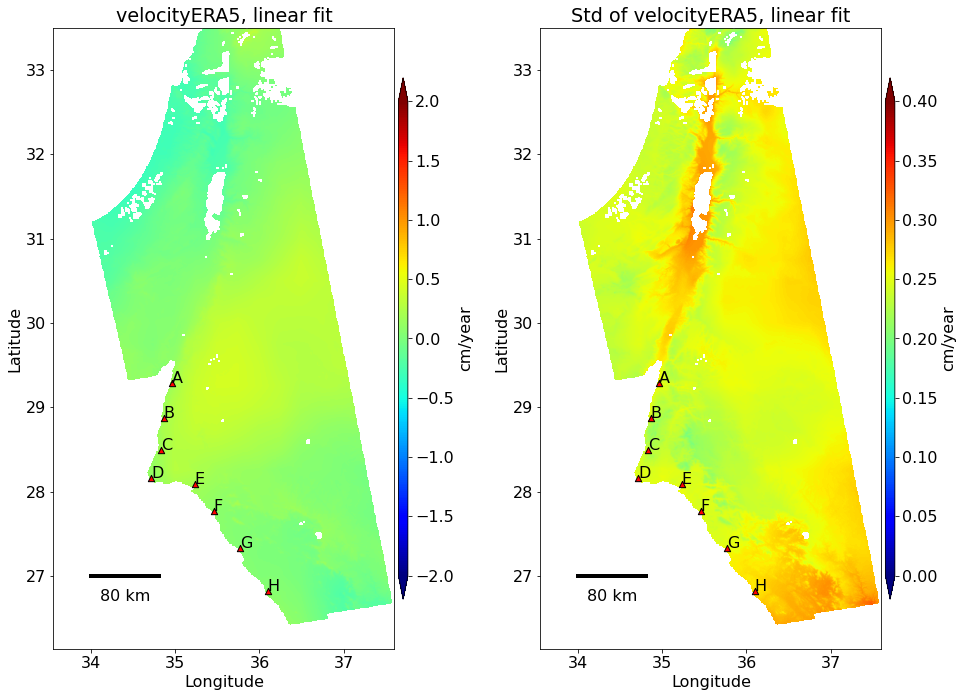

Linear + periodic fitting
save to file: /net/kraken/nobak/ykliu/aqaba/aria/a087/ts_ml10_087/pic_supp/velocity_coast_periodic_2.png


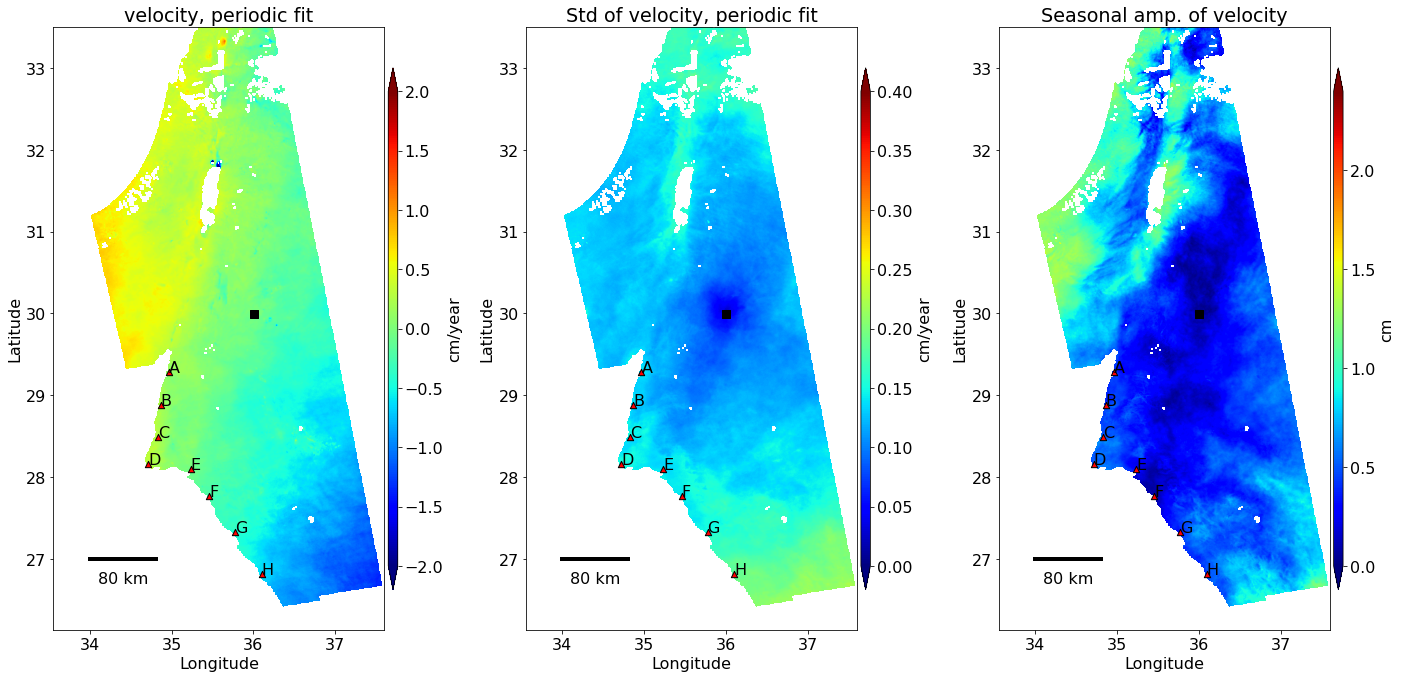

Linear + periodic fitting
save to file: /net/kraken/nobak/ykliu/aqaba/aria/a087/ts_ml10_087/pic_supp/velocityERA5_coast_periodic_2.png


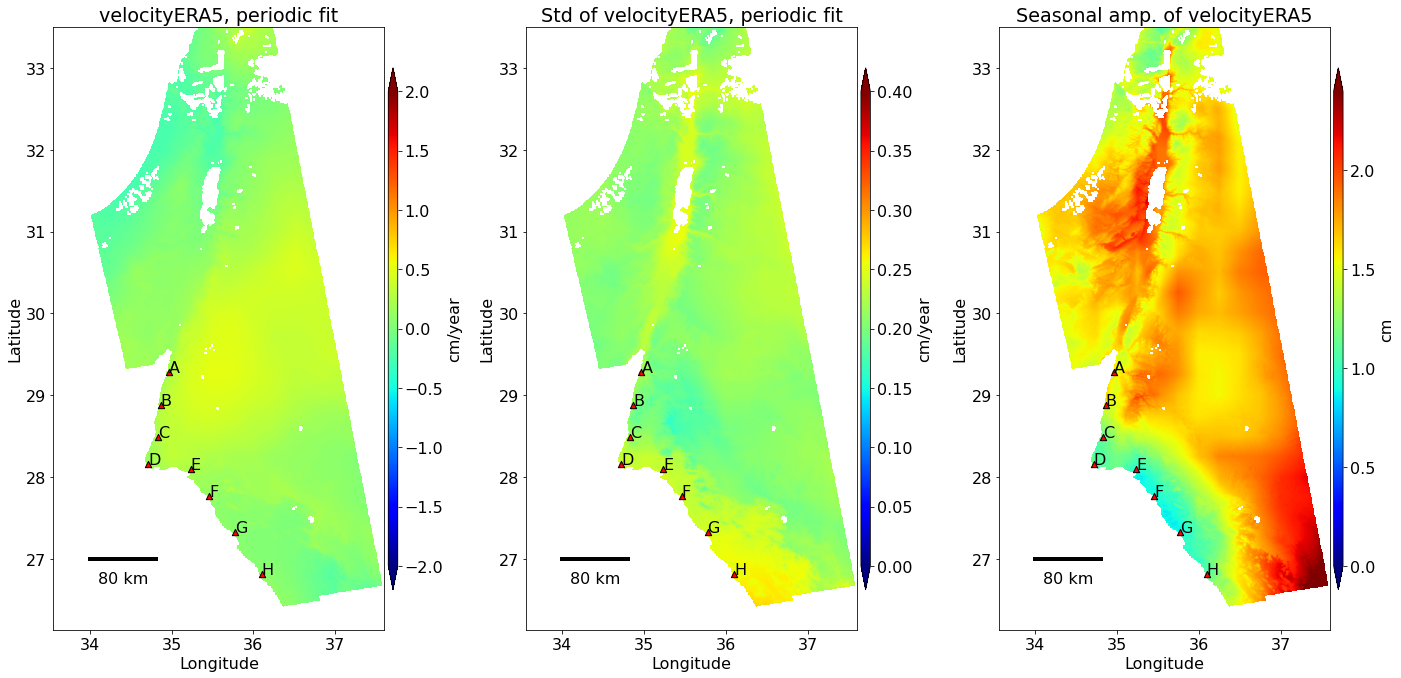

In [23]:
plot_velocitymap(data='velocity', pts='coast', model='linear')
plot_velocitymap(data='velocityERA5', pts='coast', model='linear')

plot_velocitymap(data='velocity', pts='coast', model='periodic', plot_seasonalAmp=True)
plot_velocitymap(data='velocityERA5', pts='coast', model='periodic', plot_seasonalAmp=True)

# 5. Network and time-series Residual RMS

In [38]:
from datetime import datetime
from datetime import timedelta
from mintpy.utils import utils as ut, plot as pp
    
class tsRMS():    
    def __init__(self, rms_file, k=1, cutoff=3, ifgramStack='ifgramStack_coherence_spatialAvg.txt'):
        self.rms_file = rms_file
        self.ifgramStack = ifgramStack

        in_file = open(f'./{ifgramStack}','r')
        lines = in_file.readlines()
        date12=[]
        bperp=[]
        for x in lines:
            if x[0] == '#':
                continue
            else:
                tmp = x.split()
                date12.append(tmp[0])       # date1 and date2 of an ifgram
                bperp.append(float(tmp[3])) # Unit: meter

        in_file = open(f'./{rms_file}','r')
        lines = in_file.readlines()
        dates=[]
        datestr=[]
        rms=[]
        for x in lines:
            if x[0] == '#':
                continue
            else:
                tmp = x.split()
                datestr.append(tmp[0])
                dates.append(datetime(np.int(tmp[0][:4]), np.int(tmp[0][4:6]), np.int(tmp[0][6:8]), 0, 0))
                rms.append(float(tmp[1])*1000)
        rms = np.array(rms)

        # Get noise level threshold
        rms_med = np.median(rms)
        center  = k * rms_med
        MAD  = 1.4826 * np.median(np.abs(rms - center ))
        threshold  = MAD  * cutoff + center
        
        # Print median, MAD about the residual RMS
        print('Statistics:')
        print('\t Median of RMS \t\t= {:.2f} mm'.format(rms_med))        
        print('\t MAD \t\t\t= {:.2f} mm \t (centered at {:d} * RMS median)'.format(MAD, k))
        print('\t {:d} * MAD + center \t= {:.2f} mm \t (MintPy default threshold)'.format(cutoff, threshold))


        G = np.zeros([len(date12),len(datestr)])
        for i in range(len(date12)):
            Grow=np.zeros(len(datestr))
            id1=datestr.index(date12[i].split('_')[0])
            id2=datestr.index(date12[i].split('_')[1])
            Grow[id1]=-1
            Grow[id2]=1
            G[i,:]=Grow
        bperp_est = np.linalg.lstsq(G, bperp, rcond=None)[0]
        bperp_est = bperp_est-bperp_est[0]
        
        self.dates = dates
        self.datestr = datestr
        self.date12 = date12
        self.bperp_est = bperp_est
        
        self.rms = rms
        self.rms_med = rms_med
        
        self.center  = center
        self.MAD  = MAD
        self.cutoff = cutoff               
        self.threshold  = threshold

    # ----------------------------------------------------------------------------------
    def plot_rmsHist(self, n_bin=2, supp='', threshold=False):
        fig, ax = plt.subplots(ncols=2, sharey=True, gridspec_kw={'wspace':0.02}, figsize=[14,5])
        fig.text(0.42, 0.92, f'Time-series residual RMS {supp}')
        
        vmin = np.min(self.rms)
        vmax = np.max(self.rms)
        bins = np.linspace(vmin,vmax,int((vmax-vmin)/n_bin))
        ax[0].hist(self.rms, bins, edgecolor='k')
        ax[0].axvline(x=self.rms_med   , color='k', linestyle='--', label='median')
        if threshold == True:
            ax[0].axvline(x=self.MAD       , color='b', linestyle='--', label='MAD')
            ax[0].axvline(x=self.threshold , color='r', linestyle='--', label=f'{self.cutoff}*MAD')
        ax[0].axvline(x=np.percentile(self.rms,75)  , color=0*np.ones(3), lw=0.5, label='75%')
        ax[0].axvline(x=np.percentile(self.rms,90)  , color=0.3*np.ones(3), lw=0.5, label='90%')
        ax[0].axvline(x=np.percentile(self.rms,95)  , color=0.5*np.ones(3), lw=0.5, label='95%')
        ax[0].axvline(x=np.percentile(self.rms,99.7), color=0.7*np.ones(3), lw=0.5, label='99.7%')
        ax[0].set_xlabel('RMS [mm]')
        ax[0].set_ylabel('Num of scenes')        
        ax[0].legend(frameon=False, loc='upper right')
        
        vmin = np.min(self.rms)
        vmax = np.max(self.rms)
        bins = np.linspace(np.log10(vmin),np.log10(vmax),int((vmax-vmin)/n_bin))
        ax[1].hist(np.log10(self.rms), bins, edgecolor='k')
        ax[1].axvline(x=np.log10(self.rms_med)   , color='k', linestyle='--', label='median')
        if threshold == True:
            ax[1].axvline(x=np.log10(self.MAD), color='b', linestyle='--', label='MAD')
            ax[1].axvline(x=np.log10(self.threshold), color='r', linestyle='--', label=f'{self.cutoff}*MAD')
        ax[1].axvline(x=np.percentile(np.log10(self.rms),75)  , color=0  *np.ones(3), lw=0.5, label='75%')
        ax[1].axvline(x=np.percentile(np.log10(self.rms),90)  , color=0.3*np.ones(3), lw=0.5, label='90%')
        ax[1].axvline(x=np.percentile(np.log10(self.rms),95)  , color=0.5*np.ones(3), lw=0.5, label='95%')
        ax[1].axvline(x=np.percentile(np.log10(self.rms),99.7), color=0.7*np.ones(3), lw=0.5, label='99.7%')        
        ax[1].set_xlabel('log(RMS) [-]')
        ax[1].legend(frameon=False, loc='upper right')
        plt.show()
    
    
    # ----------------------------------------------------------------------------------
    # Read SLC filename to get Mission Identifier (Sen1-A or Sen1-B)
    def MI_info(self, SLC_path, colorA='dodgerblue', colorB='tomato'):
        fns = glob.glob(f'{SLC_path}/*.zip')
        for i in range(len(fns)):
            fns[i] = fns[i].split('/')[8]
        acqs = []
        for i in range(len(self.datestr)):
            ymd = self.datestr[i]
            for j in range(len(fns)):
                if ymd == fns[j].split('1SDV_')[1][:8]:
                    mi = fns[j].split('1SDV_')[0][:3]
                    acqs.append((ymd, mi))
        acqs = sorted(list(set(acqs)))
        if len(acqs) > len(self.datestr):
            print('SLC filename reading rrror: Acqusition dates have non-unique mission identifier')
        if len(acqs) < len(self.datestr):
            lacks = sorted(list(set(self.datestr) - set(np.array(acqs)[:,0])))
            print(f'Number of dates from downloaded Sen1 SLCs = {len(acqs)}\nNumber of ARIA acquisitions = {len(self.datestr)}')
            print(f'Lack SLCs from the following {len(self.datestr)-len(acqs)} dates. Update the following dates from ASF vertex:')            
            print(f'{lacks}')

        bcolor=[]
        colorA = 'dodgerblue'
        colorB = 'tomato'
        for i in range(len(self.datestr)):
            if i < len(acqs):
                if acqs[i][1] == 'S1A':
                    bcolor.append(colorA) 
                elif acqs[i][1] == 'S1B':
                    bcolor.append(colorB)
            else:
                bcolor.append('grey')
                
        return bcolor, acqs
    
    # ----------------------------------------------------------------------------------
    def plot_network(self, SLC_path=None, return_values=False):
        from matplotlib import colors
        from matplotlib.lines import Line2D        
        
        filename = 'rms_timeseriesResidual_ramp_network'
        title = 'Interferogram network and Residual RMS'
        fig_dpi=150
        font_size=16
        plt.rcParams.update({'font.size': font_size})    
        
        dates = self.dates
        datestr =  self.datestr
        date12 = self.date12
        rms = self.rms
        bperp_est = self.bperp_est        
        
        if SLC_path is None:
            colors_over = plt.cm.Reds_r(np.linspace(0, 0.50, 256))
            colors_okay = plt.cm.YlOrRd_r(np.linspace(0.70, 1, 256))
            all_colors = np.vstack((colors_okay[::-1], colors_over[::-1]))
            rms_color = colors.LinearSegmentedColormap.from_list('rms_color',all_colors)        
            cmap = rms_color     
            divnorm = colors.TwoSlopeNorm(vmin=0, vcenter=1.5*self.MAD, vmax=3*self.MAD)
            figsize = [14,6]
        elif SLC_path is not None:
            colorA = 'dodgerblue'
            colorB = 'tomato'
            bcolor, _= self.MI_info(SLC_path, colorA, colorB)
            figsize = [12,6]

        #cmap = plt.cm.YlOrBr  # define the colormap
        #cmaplist = [cmap(i) for i in range(cmap.N)] # extract all colors from the .jet map
        ##cmaplist[0] = (.5, .5, .5, 1.0)   # force the first color entry to be grey
        #cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)  # create the new map
        #bounds = np.round(np.linspace(self.rms_med*0.8, self.MAD*3, 6))     # define the bins and normalize
        #norm = mpl.colors.BoundaryNorm(bounds, cmap.N)  
        
        fig, ax = plt.subplots(figsize=figsize)
        for i in range(len(date12)):
            id1 = datestr.index(date12[i].split('_')[0])
            id2 = datestr.index(date12[i].split('_')[1])
            ax.plot([dates[id1], dates[id2]],[bperp_est[id1], bperp_est[id2]], '-', lw=2., c='gray', alpha=0.4)
            pp.auto_adjust_xaxis_date(ax, dates, fontsize=font_size)
            plt.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True)

        if SLC_path is None:
            im=ax.scatter(dates, bperp_est, marker='o', s=200, c=rms, cmap=cmap, norm=divnorm, edgecolor='k', linewidth=1., alpha=0.8)
            fig.colorbar(im, ax=ax, cmap=cmap, label='Residual phase RMS [mm]')            
        elif SLC_path is not None:
            im=ax.scatter(dates, bperp_est, marker='o', s=200, c=bcolor, edgecolor='k', linewidth=1., alpha=0.8)
            handles = [Line2D([0],[0],marker='o',color=c,lw=1,markersize=10,markeredgecolor='k',alpha=0.8) for c in [colorA, colorB]]
            labels = ['Sen1-A','Sen1-B']
            ax.legend(handles, labels, loc='best')
        ax.set_xlabel('Time [year]')
        ax.set_ylabel('Perp Baseline [m]')
        ax.set_title(title)

        # output
        plt.tight_layout()
        out_file = f'{pic_dir}/{filename}.png'
        plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
        print('save to file: '+out_file)    
        plt.show()   
        
        if return_values == True:
            return dates, datestr
    
    # ----------------------------------------------------------------------------------
    def plot_sceneNoise(self, average=False, shift=-1, SLC_path=None, return_values=False):
        from matplotlib.patches import Rectangle        
        filename = 'rms_timeseriesResidual_ramp_hist'
        title = 'temporal noise ditribution'
        fig_dpi=150
        font_size=16
        plt.rcParams.update({'font.size': font_size})  
        
        dates = self.dates
        datestr = self.datestr
        rms = self.rms
        bperp_est = self.bperp_est
        rms_med = self.rms_med
        MAD = self.MAD
                    
        if average is True:
            filename = 'rms_timeseriesResidual_ramp_hist_seasonAvg'
            title = 'Seasonal noise distribution'
            midpoint = []
            mean_rms = []
            years = []
            for i in range(len(dates)):
                years.append(dates[i].year)
            years = sorted(list(set(years)))
            years.append(years[0]-1)
            years = sorted(years)
            for k in range(len(years)):
                year = years[k]
                window = 3
                months = np.arange(1,13,window)
                months = (months+shift)%12
                try:
                    months[np.where(months==0)[0][0]] = 12
                except:
                    pass
                
                for i in range(len(months)):
                    t1 = datetime(year,months[i],1)
                    try:
                        if months[i+1] < months[i]:
                            year = year+1
                        t2 = datetime(year,months[i+1],1)            
                    except:
                        if months[0] < months[i]:
                            year = year+1
                        t2 = datetime(year,months[0],1)            

                    midpoint.append(t1+(t2-t1)/2)
                    data = []
                    for j in range(len(dates)):
                        if (dates[j]>=t1) and (dates[j]<t2):
                            data.append(rms[j])
                    mean_rms.append(np.mean(np.array(data)))
                    idx = np.argwhere(np.isnan(mean_rms))
                    if len(idx) != 0:
                        del mean_rms[idx[0][0]]
                        del midpoint[idx[0][0]]
            dates = midpoint
            rms = mean_rms
            month_str = 'Averaged windows:\n'
            for i in range(len(months)):
                m1 = datetime(year,months[i],1).strftime("%b")
                try:
                    m2 = (datetime(year,months[i+1],1)-timedelta(days=15)).strftime("%b")
                except:
                    m2 = (datetime(year,months[0],1)-timedelta(days=15)).strftime("%b")
                month_str = month_str + f'    {m1}~{m2}\n'

        lowRMS_date = np.where(rms==np.min(rms))[0][0]
        highRMS_date = np.where(rms>3*MAD)[0]  
        
        label_thresh = 'Median Abs Deviation * 3'
        label_95per  = '95th percentile'
        label_lowRMS = 'Reference date'
        label_highRMS = f'Noisy date ({len(highRMS_date)})'
        label_SA = 'Sen1-A'
        label_SB = 'Sen1-B'
        
        bar_width = np.min(np.diff(dates).tolist())*3/4        
        
        
        fig, ax = plt.subplots(figsize=[12,6])
        line = ax.axhline(y=MAD*3                  , linestyle='--', color='k'   , lw=3, label=label_thresh) 
        line2 = ax.axhline(y=np.percentile(rms, 95), linestyle='--', color='gray', lw=3, label=label_95per)

        if SLC_path is None:
            ax.bar(dates, rms, width=bar_width.days)
            if average is False:
                lowbar = ax.bar(dates[lowRMS_date], rms[lowRMS_date], width=bar_width.days, color='orange')
                for i in range(len(highRMS_date)):
                    highbar = ax.bar(dates[highRMS_date[i]], rms[highRMS_date[i]], width=bar_width.days, color='grey')            
                try:
                    handles = [line, line2, lowbar, highbar]
                except:
                    handles = [line, line2, lowbar]
                labels= [label_thresh, label_95per, label_lowRMS, label_highRMS]   
                ax.legend(handles, labels, frameon=False)
            else:
                ax.legend(frameon=False)
        elif SLC_path is not None:
            colorA = 'dodgerblue'
            colorB = 'tomato'
            bcolor, _= self.MI_info(SLC_path, colorA, colorB)
            ax.bar(dates, rms, width=bar_width.days, color=bcolor)
            handles = [line]+[line2]+[Rectangle((0,0),1,1,color=c) for c in [colorA, colorB]]
            labels= [label_thresh, label_95per, label_SA, label_SB]
            ax.legend(handles, labels, frameon=False)
        pp.auto_adjust_xaxis_date(ax, dates, fontsize=font_size)
        ax.set_xlabel('Time [year]')
        ax.set_ylabel('Residual phase RMS [mm]')
        ax.set_title(title)
        try:
            fig.text(0.2,0.5,month_str)
        except:
            pass      
        
        
        # output
        plt.tight_layout()
        out_file = f'{pic_dir}/{filename}.png'
        plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
        print('save to file: '+out_file)    
        plt.show()
        
        if return_values == True:
            return dates, datestr

Statistics:
	 Median of RMS 		= 12.86 mm
	 MAD 			= 19.07 mm 	 (centered at 0 * RMS median)
	 3 * MAD + center 	= 57.20 mm 	 (MintPy default threshold)


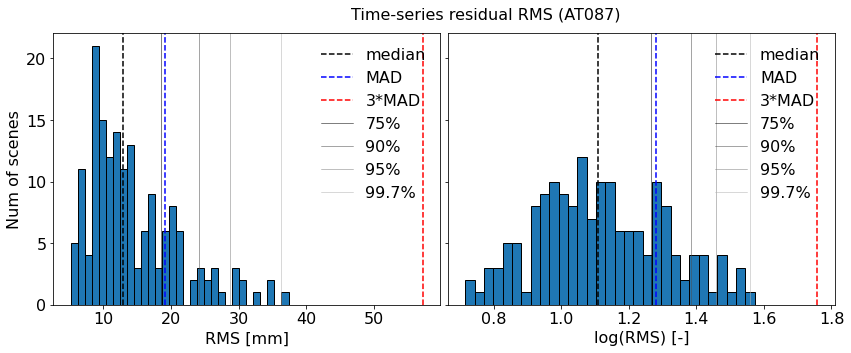

save to file: /net/kraken/nobak/ykliu/aqaba/aria/a087/ts_ml10_087/pic_supp/rms_timeseriesResidual_ramp_network.png


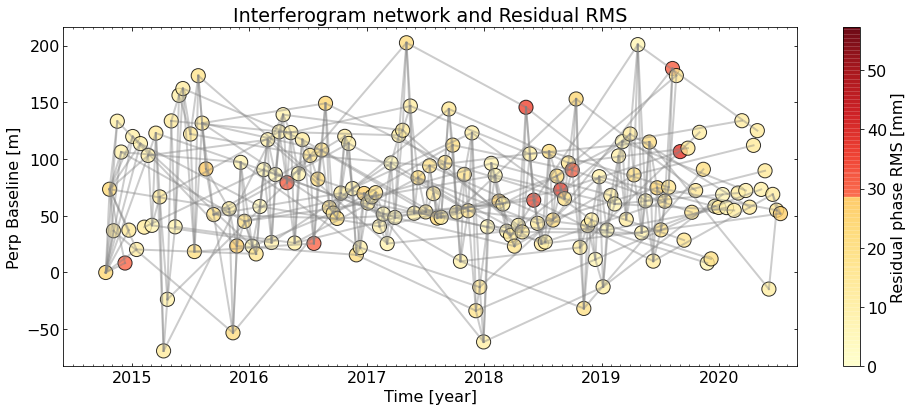

save to file: /net/kraken/nobak/ykliu/aqaba/aria/a087/ts_ml10_087/pic_supp/rms_timeseriesResidual_ramp_network.png


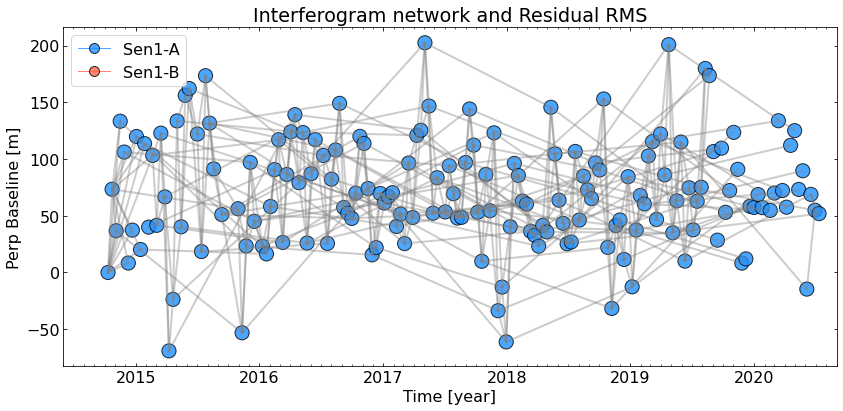

save to file: /net/kraken/nobak/ykliu/aqaba/aria/a087/ts_ml10_087/pic_supp/rms_timeseriesResidual_ramp_hist.png


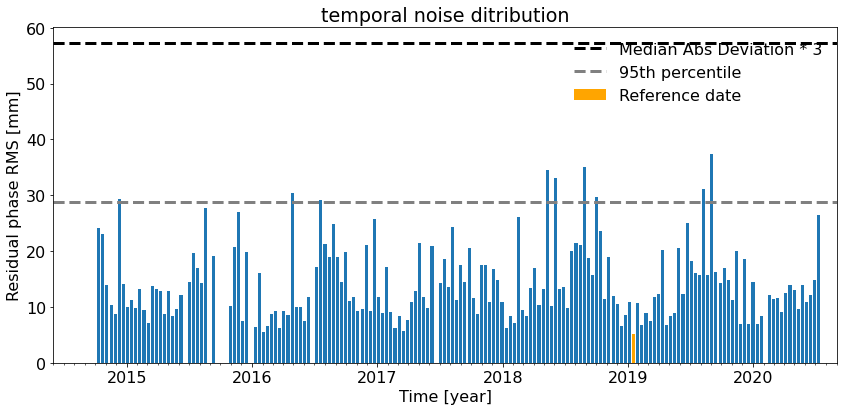

save to file: /net/kraken/nobak/ykliu/aqaba/aria/a087/ts_ml10_087/pic_supp/rms_timeseriesResidual_ramp_hist.png


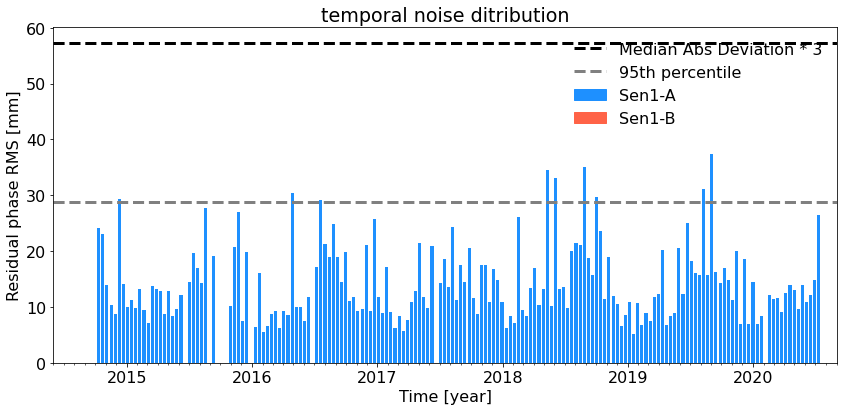

save to file: /net/kraken/nobak/ykliu/aqaba/aria/a087/ts_ml10_087/pic_supp/rms_timeseriesResidual_ramp_hist_seasonAvg.png


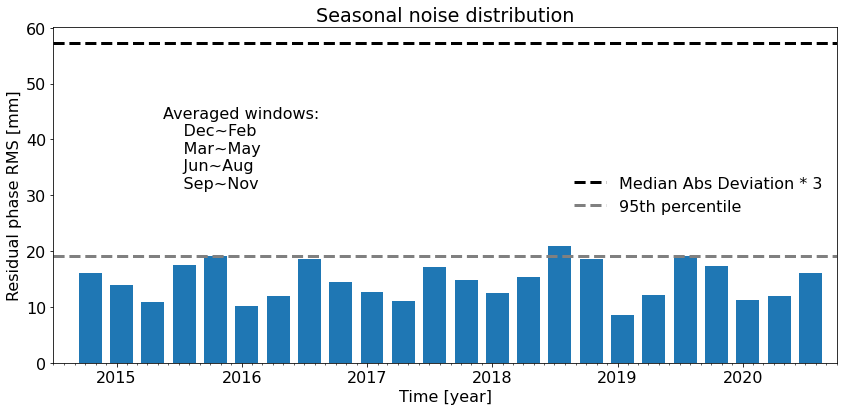

In [40]:
SLC_path = '/home/ykliu/kamb-nobak/aqaba/isce/AqabaSenAT087/data'

RMS_info = tsRMS('rms_timeseriesResidual_ramp.txt', k=0, cutoff=3)
RMS_info.plot_rmsHist(1, supp='(AT087)', threshold=True)
RMS_info.plot_network()
RMS_info.plot_network(SLC_path=SLC_path)
RMS_info.plot_sceneNoise()
RMS_info.plot_sceneNoise(SLC_path=SLC_path)
RMS_info.plot_sceneNoise(average=True)

# Supp 1. Understanding the contributions of phases


$$\phi^i_{dis} = \hat{\phi}^i - \hat{\phi}^i_{tropo} - \hat{\phi}^i_{geom} - \hat{\phi}^i_{resid}$$

$$\phi^i_{resid} = \hat{\phi}^i - \hat{\phi}^i_{tropo} - \hat{\phi}^i_{geom} - \hat{\phi}^i_{dis}$$

 - timeseries.h5: $\hat{\phi}^i$
 
 - timeseriesERA5.h5: $\hat{\phi}^i - \hat{\phi}^i_{tropo}$ = $\phi^i_{dis} + \hat{\phi}^i_{geom} + \hat{\phi}^i_{resid}$
 

We estimated the $\hat{\phi}^i_{geom}$ (for DEM errors) by assuming some polynomial deformation model $\hat{\phi}^i_{dis}$ in 
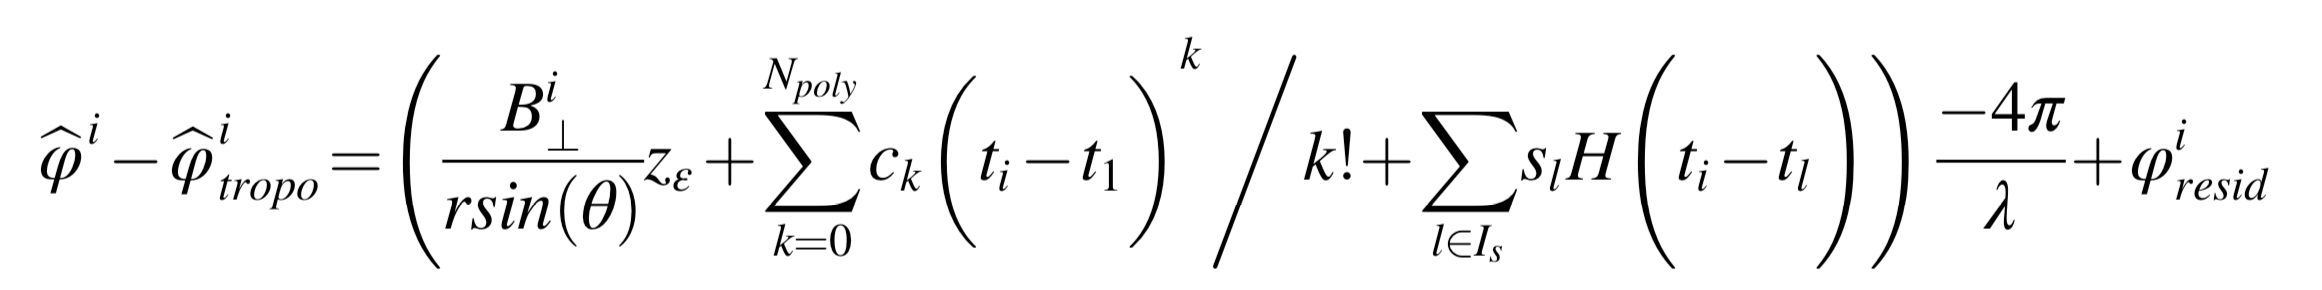

Here: $\hat{\phi}^i - \hat{\phi}^i_{tropo} = (\hat{\phi}^i_{geom}$ + $\hat{\phi}^i_{dis}) + \phi^i_{resid}$

As we are only interested in the estimation of $z^\epsilon$ here, we simply assume the deformation term $\hat{\phi}^i_{dis}$ can be account for by using some polynomial forms.

 - timeseriesERA5_demErr.h5: $\hat{\phi}^i - \hat{\phi}^i_{tropo} - \hat{\phi}^i_{geom}$ = $\phi^i_{dis} + \hat{\phi}^i_{resid}$

# Supp 2. ISCE SLCs processor veersion checking

In [67]:
s1ver_file = '/home/ykliu/kamb-nobak/aqaba/isce/AqabaSenAT087/s1_version.dat'

versions = []
with open(s1ver_file, 'r') as f:
    for line in f:
        tmp = line.split()
        try:
            MI = tmp[0][:3]
        except:
            continue
        if MI[:2] == 'S1':
            ver = tmp[2]
            versions.append(ver)

versions = sorted(list(set(versions)))
print(len(versions))        
versions

17


['002.36',
 '002.43',
 '002.51',
 '002.52',
 '002.53',
 '002.60',
 '002.62',
 '002.70',
 '002.71',
 '002.72',
 '002.82',
 '002.84',
 '002.90',
 '002.91',
 '003.10',
 '003.20',
 '003.30']

# Supp 3. Statistics of Residual for all dataset 

(141, 8825, 4846)


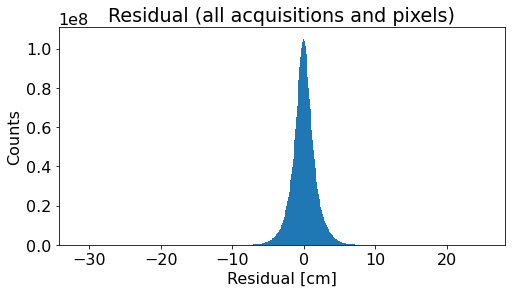

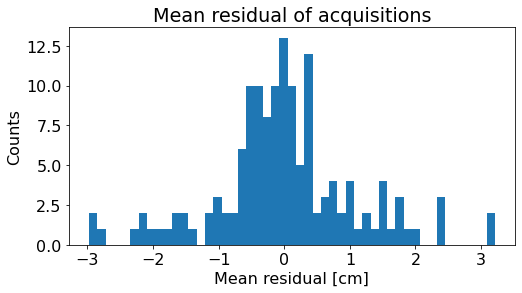

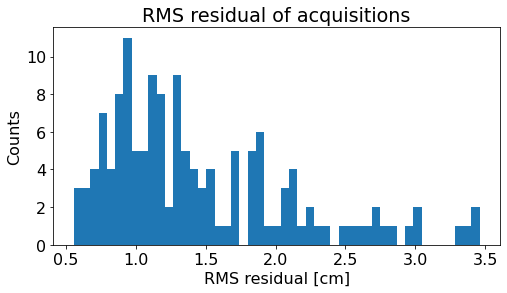

In [5]:
# Time-series residual dataset (from all acquisitions)
# Warning: Any operation/plotting here will take a few minutes because the size of array is BIG!

mask_file = mask
mask_data = readfile.read(mask_file)[0]
all_data = readfile.read(ts_file)[0].astype("float") * 100. #cm
all_data[:, mask_data==0] = np.nan

print(all_data.shape)

# Calculate the residual Mean by acquisitions
all_mean = np.zeros(all_data.shape[0])
for i in range(all_data.shape[0]):
    all_mean[i] = np.nanmean(all_data[i,:], axis=(0, 1))

# Calculate the residual RMS by acquisitions
all_rms = np.zeros(all_data.shape[0])
for i in range(all_data.shape[0]):
    all_rms[i] = np.sqrt(np.nanmean(np.square(all_data[i,:]), axis=(0, 1)))


data = all_data[~np.isnan(all_data)]
plt.figure(figsize=[8,4])
bins = np.linspace(np.min(data), np.max(data), 500)
plt.hist(data, bins)
plt.xlabel('Residual [cm]')
plt.ylabel('Counts')
plt.title('Residual (all acquisitions and pixels)')
plt.show()

plt.figure(figsize=[8,4])
bins = np.linspace(np.min(all_mean), np.max(all_mean), 50)
plt.hist(all_mean, bins)
plt.xlabel('Mean residual [cm]')
plt.ylabel('Counts')
plt.title('Mean residual of acquisitions')
plt.show()

plt.figure(figsize=[8,4])
bins = np.linspace(np.min(all_rms), np.max(all_rms), 50)
plt.hist(all_rms, bins)
plt.xlabel('RMS residual [cm]')
plt.ylabel('Counts')
plt.title('RMS residual of acquisitions')
plt.show()

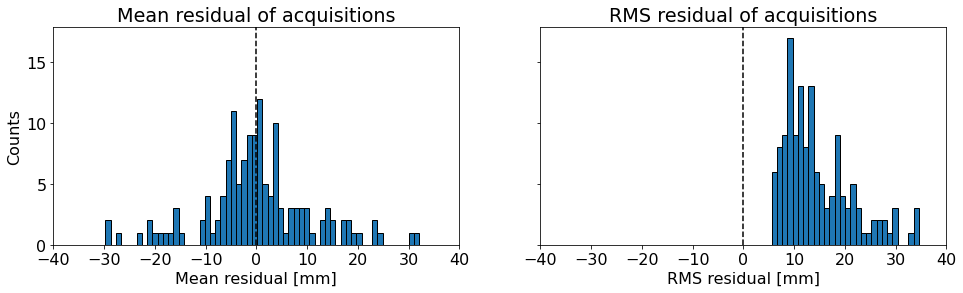

In [15]:
vmin = np.min(all_mean*10)
vmax = np.max(all_mean*10)
bins = np.linspace(vmin,vmax,int((vmax-vmin)/1))

fig, ax = plt.subplots(ncols=2, sharey=True, figsize=[16,4])
ax[0].hist(all_mean*10, bins, edgecolor='k')
ax[0].axvline(x=0, c='k', linestyle='--')
ax[0].set_xlim([-40,40])
ax[0].set_xlabel('Mean residual [mm]')
ax[0].set_ylabel('Counts')
ax[0].set_title('Mean residual of acquisitions')


vmin = np.min(all_rms*10)
vmax = np.max(all_rms*10)
bins = np.linspace(vmin,vmax,int((vmax-vmin)/1))

ax[1].hist(all_rms*10, bins, edgecolor='k')
ax[1].axvline(x=0, c='k', linestyle='--')
ax[1].set_xlim([-40,40])
ax[1].set_xlabel('RMS residual [mm]')
ax[1].set_title('RMS residual of acquisitions')
plt.show()